## Tutorial for `Type1` problem

In this tutorial we will go over type 1 optimization problem which entails `nn.Module` rerpesented cost function and __no constarint__ at all.
This type of problem is often written as follows:

$$ \min_{x} f_{\theta}(x) $$

we can find `Type1` problems quite easily. For instance assuming you are the manager of some manufactoring facilities, then your primary objective would be to maximize the yield of the manufactoring process. In industrial grade of manufactoring process the model of process is often __unknown__. hence we may need to learn the model through your favorite differentiable models such as neural networks and perform the graident based optimization to find the (local) optimums that minimize (or maximize) the yield.

### General problem solving tricks; Cast your problem into QP, approximately.

As far as I know, Convex optimization is the most general class of optmization problems where we have algorithms that can solve the problem optimally. Qudartic progamming (QP) is a type of convex optimization problems which is well developed in the side of theory and computations. We will heavily utilize QPs to solve the optimziation problems that have dependency with `torch` models.

Our general problem solving tricks are as follows:
1. Construct the cost or constraint models from the data
2. By utilizting `torch` automatic differentiation functionality, compute the jacobian or hessians of the moodels.
3. solve (possibley many times) QP with the estimated jacobian and hessians.

> It is noteworthy that even we locally cast the problem into QP, that doesn't mean our original problem is convex. Therefore, we cannot say that this approahces we will look over can find the global optimum.

### The convexity of the optimization problems
when the objective function and the constriants are convex with respect to the optimization variblbes, then the optimization problem is convex. This tutorial doesn't assume any convexity conditions on the optimization problems, especially on models. therefore, we cannot say anything about the quality of solutions. However, in practical setups, even local optimum could be helpful.

>There's few study that how can we impose the input convexity (that is, the neural network approximate the convex functions of inputs).  For the interested readers, I recommend to read following manuscripts.
> 1. [Input Convex Neural Networks](https://github.com/locuslab/icnn)
> 2. [Optimal Control via Nerual Networks: A convex approach](https://arxiv.org/abs/1805.11835)

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

from src.utils import generate_y
from src.MLP import MLP

## Generate training dataset


In [2]:
x_min, x_max = -4.0, 4.0

xs_linspace = torch.linspace(-4, 4, 2000).view(-1, 1)
ys_linspace = generate_y(xs_linspace)

# samples to construct training dataset
x_dist = torch.distributions.uniform.Uniform(-4.0, 4.0)
xs = x_dist.sample(sample_shape=(500, 1))
ys = generate_y(xs)

In [3]:
BS = 64 # Batch size
ds = TensorDataset(xs, ys)
loader = DataLoader(ds, batch_size=BS, shuffle=True)

## Construct model

Since we assume we don't have access to the system $f(x)$, we are goint to train a model and use the model $f_\theta(x)$ as the surrogate of the system.
In this tutorial, we use a MultiLayer Perceptron to approximate $f(x)$. We additionaly assume the obsevation data is noisy-free.

In [5]:
input_dim, output_dim = 1, 1
m = MLP(input_dim, output_dim, num_neurons=[128, 128])
mse_criteria = torch.nn.MSELoss()
opt = torch.optim.Adam(m.parameters(), lr=1e-3)

In [6]:
input_dim, output_dim = 1, 1
m = MLP(input_dim, output_dim, num_neurons=[128, 128])
mse_criteria = torch.nn.MSELoss()
opt = torch.optim.Adam(m.parameters(), lr=1e-3)

In [7]:
n_update = 0
print_every = 500
epochs = 200
for _ in range(epochs):
    for x, y in loader:        
        y_pred = m(x)
        loss = mse_criteria(y_pred, y)
        opt.zero_grad()
        loss.backward()
        opt.step()

        n_update += 1
        if n_update % print_every == 0:
            print(n_update, loss.item())

500 0.057296015322208405
1000 0.005133075639605522
1500 0.0004854210710618645


In [8]:
# save model for the later usages
torch.save(m.state_dict(), './model.pt')

## Solve the unconstraint optimization problem
Let's solve the unconstraint optimization problem with torch estmiated graidents and simple gradient descent method.



In [9]:
def minimize_y(x_init, model, num_steps=15, step_size=1e-1):
    def _grad(model, x):
        return torch.autograd.functional.jacobian(model, x).squeeze()
    
    x = x_init
    
    xs = [x]
    ys = [model(x)]
    gs = [_grad(model, x)]
    for _ in range(num_steps):
        grad = _grad(model, x)
        x = (x- step_size * grad).clone()
        y = model(x)
        
        xs.append(x)
        ys.append(y)
        gs.append(grad)
        
    
    xs = torch.stack(xs).detach().numpy()
    ys = torch.stack(ys).detach().numpy()
    gs = torch.stack(gs).detach().numpy()    
    return xs, ys, gs

In [11]:
x_min, x_max = -4.0, 4.0
n_steps = 40

x_init = torch.tensor(np.random.uniform(x_min, x_max, 1)).float()
opt_xs, opt_ys, grad = minimize_y(x_init, m, n_steps)

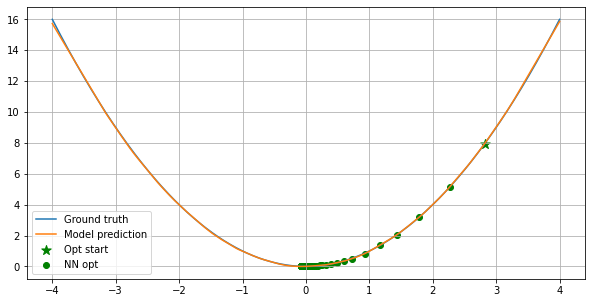

In [12]:
pred_ys = m(xs_linspace).detach()


fig, axes = plt.subplots(1, 1, figsize=(10, 5))
axes.grid()
axes.plot(xs_linspace, ys_linspace, label='Ground truth')
axes.plot(xs_linspace, pred_ys, label='Model prediction')

axes.scatter(opt_xs[0], opt_ys[0], label='Opt start', 
             c='green', marker='*', s=100.0)
axes.scatter(opt_xs[1:], opt_ys[1:], label='NN opt', c='green')
_ = axes.legend()